# Create a dataset of cumulative per library over time

In [34]:
import pandas as pd

questions_per_library = pd.read_csv('stackoverflow.zip', parse_dates = True, index_col = 'creation_date'
                                  ).loc[:,'pandas':'bokeh'].resample('1M').sum().cumsum().reindex(
                                    pd.date_range('2008-08', '2021-10', freq = 'M')
                                    ).fillna(0)
questions_per_library.tail()

,pandas,matplotlib,numpy,seaborn,geopandas,geoviews,altair,yellowbrick,vega,holoviews,hvplot,bokeh
2021-05-31,200734.0,57853.0,89812.0,6855.0,1456.0,57.0,716.0,46.0,532.0,513.0,84.0,4270.0
2021-06-30,205065.0,58602.0,91026.0,7021.0,1522.0,57.0,760.0,48.0,557.0,521.0,88.0,4308.0
2021-07-31,209235.0,59428.0,92254.0,7174.0,1579.0,62.0,781.0,50.0,572.0,528.0,89.0,4341.0
2021-08-31,213410.0,60250.0,93349.0,7344.0,1631.0,62.0,797.0,52.0,589.0,541.0,92.0,4372.0
2021-09-30,214919.0,60554.0,93797.0,7414.0,1652.0,63.0,804.0,54.0,598.0,542.0,92.0,4386.0


In [35]:
from matplotlib.animation import FuncAnimation

In [36]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def bar_plot(data):
    fig, ax = plt.subplots(figsize=(8,6))
    sort_order = data.last('1M').squeeze().sort_values().index
    bars = [
        bar.set_label(label) for label, bar in
        zip(sort_order, ax.barh(sort_order, [0] * data.shape[1]))
    ]
    
    ax.set_xlabel('total questions', fontweight = 'bold')
    ax.set_xlim(0, 250_000)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    fig.tight_layout()
    return fig, ax

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2552ad8d580>)

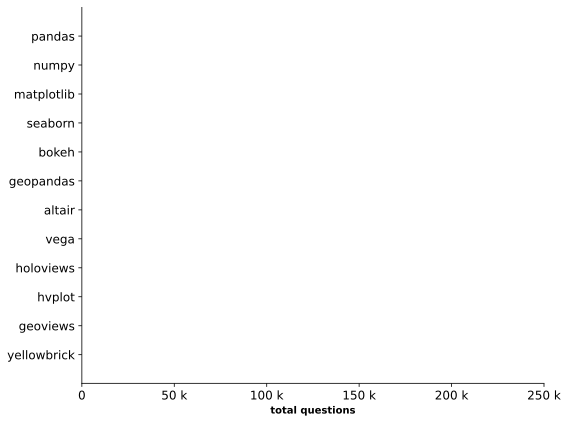

In [37]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
bar_plot(questions_per_library)

In [38]:
def generate_plot_text(ax):
    annotations = [
        ax.annotate(
            '', xy = (0, bar.get_y() + bar.get_height()/2),
            ha = 'left', va = 'center'
        ) for bar in ax.patches
    ]
    
    time_text = ax.text(
        0.9, 0.1, '', transform = ax.transAxes,
        fontsize = 15, ha = 'center', va = 'center')
    return annotations, time_text

In [39]:
def update(frame,*,ax,df,annotations,time_text):
    data=df.loc[frame,:]
    
    #update bars
    for rect, text in zip(ax.patches, annotations):
        col = rect.get_label()
        if data[col]:
            rect.set_width(data[col])
            text.set_x(data[col])
            text.set_text(f'{data[col]:,.0f}')
     #update time
    time_text.set_text(frame.strftime('%b\n%Y'))

In [40]:
from functools import partial
def bar_plot_init(questions_per_library):
    fig,ax = bar_plot(questions_per_library)
    annotations, time_text=generate_plot_text(ax)
    
    bar_plot_update=partial(
        update, ax=ax, df=questions_per_library,
        annotations=annotations, time_text=time_text
    )
    
    return fig, bar_plot_update

MovieWriter ffmpeg unavailable; trying to use pillow instead.


TypeError: 'str' object is not callable

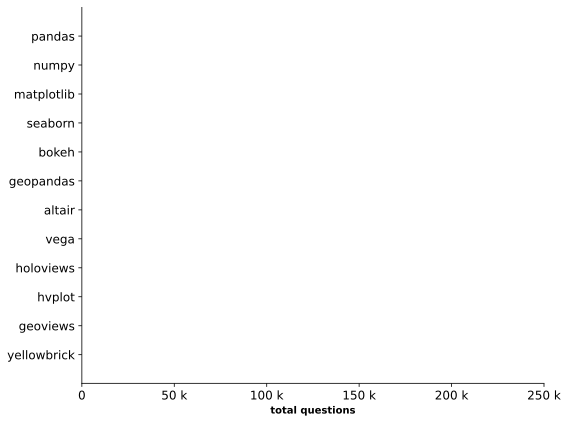

In [41]:
fig, update_func=bar_plot_init(questions_per_library)

ani =FuncAnimation(
    fig,update_func, frames=questions_per_library.index,repeat=False
)
ani.save(
    'stackoverflow_questions.mp4',
    writer='ffmpeg',fps=30,bitrate=100,dpi=300
)
plt.close()

In [43]:
from IPython import display

display.Video(
    'stackoverflow_questions.json', width = 600, height = 400,
    embed = True, html_attributes = 'controls muted autoplay'
)

# Create a dataset of daily subway entries 

In [1]:
import pandas as pd
subway = pd.read_csv('NYC_subway_daily.csv',parse_dates=['Datetime'],index_col=['Borough','Datetime']
                )
subway_daily = subway.unstack(0)
subway_daily.head()

D:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Entries                                    Exits             
Borough            Bk        Bx          M         Q        Bk        Bx   
Datetime                                                                   
2017-02-04   617650.0  247539.0  1390496.0  408736.0  417449.0  148237.0  \
2017-02-05   542667.0  199078.0  1232537.0  339716.0  405607.0  139856.0   
2017-02-06  1184916.0  472846.0  2774016.0  787206.0  761166.0  267991.0   
2017-02-07  1192638.0  470573.0  2892462.0  790557.0  763653.0  270007.0   
2017-02-08  1243658.0  497412.0  2998897.0  825679.0  788356.0  275695.0   

                                 
Borough             M         Q  
Datetime                         
2017-02-04  1225689.0  279699.0  
2017-02-05  1033610.0  268626.0  
2017-02-06  2240027.0  537780.0  
2017-02-07  2325024.0  544828.0  
2017-02-08  2389534.0  559639.0

In [2]:
manhattan_entries = subway_daily['Entries']['M']

In [3]:
import numpy as np
count_per_bin, bin_ranges = np.histogram(manhattan_entries, bins=30)

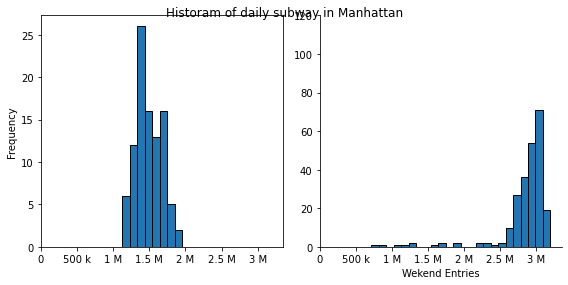

In [17]:
import matplotlib.pyplot as plt
from matplotlib import ticker
def subway_histogram(data,bins,date_range):
    _,bin_ranges = np.histogram(data,bins=bins)
    
    weekday_mask = data.index.weekday < 5
    configs = [
        {'label':'Weekend','mask': ~weekday_mask, 'ymax':60},
         {'label':'Wekend','mask': weekday_mask, 'ymax':120}
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(8,4),sharex=True)
    for ax, config in zip(axes, configs):
        _,_,config['hist'] = ax.hist(
            data[config['mask']].loc[date_range], bin_ranges, ec='black'
        )
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set(
        xlim=(0, None), ylim=(0, config['ymax']),
        xlabel=f'{config["label"]} Entries'
    )
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    axes[0].set_ylabel('Frequency')
    fig.suptitle('Historam of daily subway in Manhattan')
    fig.tight_layout()
    return fig,axes,bin_ranges, configs

_ = subway_histogram(manhattan_entries, bins=30, date_range='2017')

In [28]:
def add_time_text(ax):
    time_text = ax.text(
    0.15, 0.9, '',transform=ax.transAxes,
        fontsize=15, ha='center',va='center'
    )
    return time_text

In [29]:
def update(frame, *,data,configs,time_text,bin_ranges):
    artists = []
    
    time = frame.strftime('%b\n%Y')
    if time != time_text.get_text():
        time_text.set_text(time)
        artists.append(time_text)
        
    for config in configs:
        time_frame_mask = \
        (data.index > frame - pd.Timedelta(days=365)) & (data.index <= frame)
        counts, _= np.histogram(
            data[time_frame_mask & config['mask']],
            bin_ranges
        )
        for count, rect in zip(counts, config['hist'].patches):
            if count != rect.get_height():
                rect.set_height(count)
                artists.append(rect)
                return artists

In [30]:
from functools import partial
def histogram_init(data,bins,initial_date_range):
    fig, axes, bin_ranges, configs = subway_histogram(data, bins, initial_date_range)
    
    update_func = partial(
        update, data = data,configs=configs,
        time_text=add_time_text(axes[0]),
        bin_ranges=bin_ranges
    )
    return fig, update_func

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\matplotlib\animation.py", line 951, in _start
    self._init_draw()
  File "D:\Anaconda\lib\site-packages\matplotlib\animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "D:\Anaconda\lib\site-packages\matplotlib\animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-29-3d87cf132036>", line 16, in update
    for count, rect in zip(counts, config['hist'].patches):
AttributeError: 'silent_list' object has no attribute 'patches'
MovieWriter ffmpeg unavailable; trying to use pillow instead.


TypeError: 'str' object is not callable

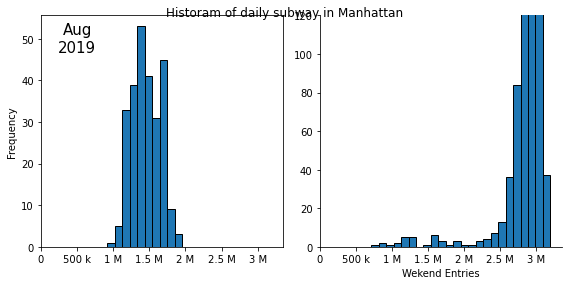

In [33]:
from matplotlib.animation import FuncAnimation
from functools import partial
fig, update_func = histogram_init(
    manhattan_entries, bins = 30, initial_date_range=slice('2017','2019-07')
)
ani = FuncAnimation(
    fig, update_func, frames=manhattan_entries['2019-08':'2021'].index,
    repeat=False, blit=True
)
ani.save(
    '/subway.gif',
    writer='ffmpeg',fps=30,bitrate=500,dpi=300
)
plt.close()